# Tweet sentiment analysis

In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

#for data analysis and modeling
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential


# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# general NLP preprocessing and basic tools
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#for text cleaning
import string
import re

# train/test split
from sklearn.model_selection import train_test_split
# basic machine learning models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
# our evaluation metric for sentiment classification
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eurecom-aml-2022-challenge-3/sample_submission.csv
/kaggle/input/eurecom-aml-2022-challenge-3/train.csv
/kaggle/input/eurecom-aml-2022-challenge-3/test.csv


## Loading the data

In [3]:
train_df = pd.read_csv('/kaggle/input/eurecom-aml-2022-challenge-3/train.csv')
test_df = pd.read_csv('/kaggle/input/eurecom-aml-2022-challenge-3/test.csv')

## Data Analysis

In [4]:
print("Number of tweets in training set:", len(train_df))
print("Number of tweets in testing set:", len(test_df))
print("Number of tweets in train and test sets together:", len(train_df)+len(test_df))

Number of tweets in training set: 24732
Number of tweets in testing set: 2748
Number of tweets in train and test sets together: 27480


In [5]:
train_df.head()

,textID,text,selected_text,sentiment
0,28ac06f416,good luck with your auction,good luck with your auction,positive
1,92098cf9a7,Hmm..You can`t judge a book by looking at its ...,Hmm..You can`t judge a book by looking at its ...,neutral
2,7858ff28f2,"Hello, yourself. Enjoy London. Watch out for ...",They`re mental.,negative
3,b0c9c67f32,We can`t even call you from belgium sucks,m suck,negative
4,7b36e9e7a5,not so good mood..,not so good mood..,negative


In [6]:
test_df.head()

,textID,text,selected_text
0,102f98e5e2,Happy Mother`s Day hahaha,Happy Mother`s Day
1,033b399113,"Sorry for the triple twitter post, was having ...","Sorry for the triple twitter post, was having ..."
2,c125e29be2,thats much better than the flu syndrome!,thats much better
3,b91e2b0679,Aww I have a tummy ache,tummy ache
4,1a46141274,hey chocolate chips is good. i want a snack ...,good.


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


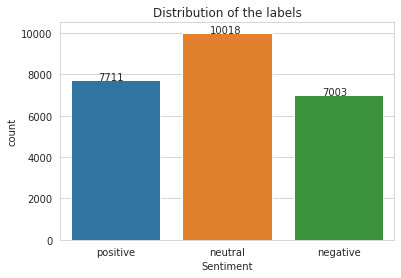

In [7]:
ax = sns.countplot(train_df.sentiment)
plt.xlabel('Sentiment')
plt.title('Distribution of the labels')
for p in ax.patches:
   ax.annotate(p.get_height(), (p.get_x()+0.25, p.get_height()+0.01))
#plt.savefig("distribution.png")

In [8]:
print("Number of missing values: ", train_df.isnull().sum().sum())

Number of missing values:  0


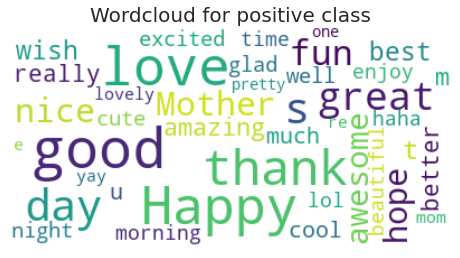

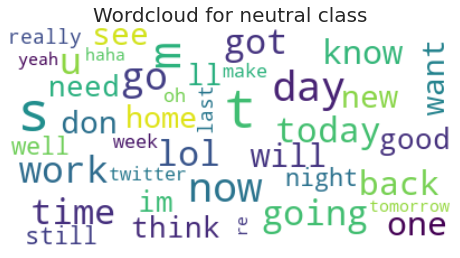

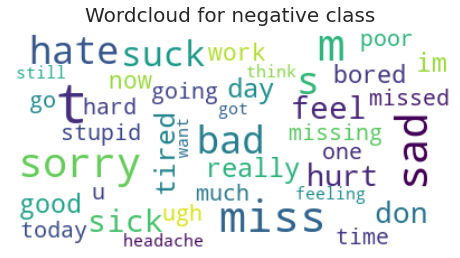

In [9]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
#stopwords.update(["yourword"]) #adding customized stopwords
wordcloud = WordCloud(stopwords=stopwords,max_font_size=50,max_words=40,collocations=False, background_color='white').generate(" ".join(review for review in train_df[train_df.sentiment=='positive']['selected_text']))

# plt.subplot(1,3,1)
plt.figure(figsize=(8,8))
plt.title("Wordcloud for positive class", fontsize=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud2 = WordCloud(stopwords=stopwords,max_font_size=50,max_words=40,collocations=False, background_color='white').generate(" ".join(review for review in train_df[train_df.sentiment=='neutral']['selected_text']))
# plt.subplot(1,3,2)
plt.figure(figsize=(8,8))
plt.title("Wordcloud for neutral class", fontsize=20)
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud3 = WordCloud(stopwords=stopwords,max_font_size=50,max_words=40,collocations=False, background_color='white').generate(" ".join(review for review in train_df[train_df.sentiment=='negative']['selected_text']))
# plt.subplot(1,3,3)
plt.figure(figsize=(8,8))
plt.title("Wordcloud for negative class", fontsize=20)
plt.imshow(wordcloud3, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
cnt_1, cnt_2, cnt_3 = 0, 0, 0
max_len, min_len, mean_len = -float("inf"), float("inf"), 0
for row in train_df.values:
    tweet = row[2]  # 1 for text, 2 for selected_text
    if "@" in tweet:
        cnt_1 += 1
    if "#" in tweet:
        cnt_2 += 1
    if 'http' or 'www' in tweet:
        cnt_3 += 1
    if len(tweet) < min_len:
        min_len = len(tweet)
    if len(tweet) > max_len:
        max_len = len(tweet)

    mean_len += len(tweet)
    
mean_len /= len(train_df)
    
print(f'Number of texts having mentions: {cnt_1}')
print(f'Number of texts having hashtags: {cnt_2}')
print(f'Number of texts having urls: {cnt_3}')
print(f'min_len:{min_len} max_len:{max_len} mean_len:{mean_len}')

Number of texts having mentions: 106
Number of texts having hashtags: 238
Number of texts having urls: 24732
min_len:1 max_len:141 mean_len:36.63334950671195


## Data Preprocessing

In [11]:
import spacy
import nltk
from nltk.corpus import stopwords
import re
import string
from emoji import demojize

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
punc_list = string.punctuation
ps = nltk.PorterStemmer()

In [12]:
chat_dict = dict([("hmmyou",""),("sry","sorry"),("inlove","in love"),("thats",""),("wanna",""),
                  ("soo","so"),("inlove","in love"),("amazingwell","amazing well"),
                  ("messagesorry","message sorry"),("½",""),("tomorrowneed","tomorrow need"),
                  ("tomorrowis","tomorrow is"),("amusedtime","amused time"),("weekendor","weekend or"),
                  ("competitionhope","competition hope"),("partypicnic","party picnic"),
                  ("ahmazing","amazing"),("wont","will not"),("didnt","did not"),("dont","do not"),
                  ("lookin","looking"),("u","you"),("youre","you are"),("nite","night"),("isnt","is not"),
                  ("k",""),("is",""),("doesnt","does not"),("l",""),("x",""),("c",""),("ur","your"),
                  ("e",""),("yall","you all"),("he",""),("us",""),("okim","ok i am"),("jealousi","jealous"),
                  ("srry","sorry"),("itll","it will"),("vs",""),("weeknend","weekend"),("w",""),
                  ("yr","year"),("youve","you have"),("havent","have not"),("iï",""),("gonna","going to"),
                  ("gimme","give me"),("ti",""),("ta",""),("thru","through"),("th",""),("imma","i am going to"),
                  ("wasnt","was not"),("arent","are not"), ("bff","best friend forever"),("sometimesdid","sometimes did"),
                  ("waitt","wait"),("bday","birthday"),("toobut","too but"),("showerand","shower and"),
                  ("innit","is not it"),("surgury","surgery"),("soproudofyo","so proud of you"),("p",""),
                  ("couldnt","could not"),("dohforgot","forgot"),("rih","right"),("b",""),("bmovie","movie"),
                  ("pleaseyour","please your"),("tonite","tonight"),("grea","great"),("se",""),("soonso","soon so"),
                  ("gettin","getting"),("blowin","blowing"),("coz","because"),("thanks","thank"),("st",""),("rd",""),
                  ("gtta","have got to"),("gotta","have got to"),("anythingwondering","anything wondering"),
                  ("annoyedy","annoyed"),("p",""),("beatiful","beautiful"),("multitaskin","multitasking"),
                  ("nightmornin","night morning"),("thankyou","thank you"),("iloveyoutwoooo","i love you two"),
                  ("tmwr","tomorrow"),("wordslooks","words looks"),("ima","i am going to"),("liek","like"),("mr",""),
                  ("allnighter","all nighter"),("tho","though"),("ed",""),("fyou",""),("footlong","foot long"),
                  ("placepiggy","place piggy"),("semiflaky","semi flaky"),("gona","going to"),("tmr","tomorrow"),
                  ("ppl","people"),("n",""),("dis","this"),("dun","done"),("houseee","house"),("havee","have"),
                  ("studyingwhew","studying whew"),("awwyoure","aww you are"),("softyi","softy"),
                  ("weddingyou","wedding you"),("hassnt","has not"),("lowerleft","lower left"),("anywayss","anyway"),
                  ("adoarble","adorable"),("blogyeahhhh","blog yeahhhh"),("billsim","bills i am"),("ps",""),
                  ("cheescake","cheesecake"),("morningafternoonnight","morning after noon night"),
                  ("allstudying","all studying"),("ofcoooursee","of course"),("jst","just"),("shes","she is"),
                  ("sonicswhich","sonics which"),("ouchwaited","ouch waited"),("itll","it will"),("orreply","or reply"),
                  ("somethin","something"),("fridayand","friday and"),("outta","out of"),("herenever","here never"), 
                  ("ain't","am not "),("aren't","are not"),("can't","cannot"),("can't've","cannot have"),("'cause","because"),
                  ("could've", "could have"),("couldn't", "could not"),("couldn't've", "could not have"),("didn't", "did not"),
                  ("doesn't", "does not"),("don't", "do not"),("hadn't", "had not"),("hadn't've", "had not have"),("hasn't", "has not"),
                  ("haven't", "have not"),("he'd", "he had / he would"),("he'd've", "he would have"),("he'll", "he shall / he will"),
                  ("he'll've", "he will have"),("he's", "he has / he is"),("how'd", "how did"),("how'd'y", "how do you"),
                  ("how'll", "how will"),("how's", "how is"),("i'd", "I had"),("i'd've", "I would have"),("i'll", "I will"),
                  ("i'll've", "I will have"),("i'm", "I am"),("i've", "I have"),("isn't", "is not"),("it'd", "it would"),("it'd've", "it would have"),
                  ("it'll", "it will"),("it'll've", "it will have"),("it's", "it is"),("let's", "let us"),("ma'am", "madam"),
                  ("mayn't", "may not"),("might've", "might have"),("mightn't", "might not"),("mightn't've", "might not have"),
                  ("must've", "must have"),("mustn't","must not"),("mustn't've", "must not have"),("needn't", "need not"),
                  ("needn't've", "need not have"),("o'clock", "of the clock"),("oughtn't", "ought not"),("oughtn't've", "ought not have"),
                  ("shan't", "shall not"),("sha'n't", "shall not"),("shan't've", "shall not have"),("she'd", "she would"),
                  ("she'd've", "she would have"),("she'll", "she will"),("she'll've","she will have"),("she's", "she is"),
                  ("should've", "should have"),("shouldn't","should not"),("shouldn't've", "should not have"),("so've", "so have"),
                  ("so's", "so is"),("that'd", "that had"),("that'd've","that would have"),("that's", "that is"),("there'd", "there would"),
                  ("there'd've", "there would have"),("there's", "there is"),("they'd", "they had"),("they'd've", "they would have"),
                  ("they'll", "they will"),("they'll've", "they will have"),("they're", "they are"),("they've", "they have"),
                  ("to've", "to have"),("wasn't", "was not"),("we'd", "we had / we would"),("we'd've", "we would have"),
                  ("we'll", "we will"),("we'll've", "we will have"),("we're", "we are"),("we've", "we have"),("weren't", "were not"),
                  ("what'll", "what will"),("what'll've", "what will have"),("what're", "what are"),("what's", "what is"),
                  ("what've", "what have"),("when's", "when is"),("when've", "when have"),("where'd", "where did"),("where's", "where is"),
                  ("where've", "where have"),("who'll", "who will"),("who'll've", "who will have"),("who's", "who is"),("who've", "who have"),
                  ("why's", "why is"),("why've", "why have"),("will've", "will have"),("won't", "will not"),("won't've", "will not have"),
                  ("would've", "would have"),("wouldn't", "would not"),("wouldn't've", "would not have"),("y'all", "you all"),("y'all'd", "you all would"),
                  ("y'all'd've", "you all would have"),("y'all're", "you all are"),("y'all've", "you all have"),("you'd", "you had"),
                  ("you'd've", "you would have"),("you'll", "you will"),("you'll've", "you will have"),("you're", "you are"),("you've", "you have")
                ])

ABBREV_DICT = dict([("AFAIK","As Far As I Know"),("AFK","Away From Keyboard"),("ASAP","As Soon As Possible"),
                  ("ATK","At The Keyboard"),("ATM","At The Moment"),("A3","Anytime, Anywhere, Anyplace"),
                  ("BAK","Back At Keyboard"),("BBL","Be Back Later"),("BBS","Be Back Soon"),("BFN","Bye For Now"),
                  ("B4N","Bye For Now"),("BRB","Be Right Back"),("BRT","Be Right There"),("BTW","By The Way"),
                  ("B4","Before"),("B4N","Bye For Now"),("CU","See You"),("CUL8R","See You Later"),("CYA","See You"),
                  ("FAQ","Frequently Asked Questions"),("FC","Fingers Crossed"),("FWIW","For What It's Worth"),
                  ("FYI","For Your Information"),("GAL","Get A Life"),("GG","Good Game"),("GN","Good Night"),
                  ("GMTA","Great Minds Think Alike"),("GR8","Great!"),("G9","Genius"),("IC","I See"),
                  ("ICQ","I Seek you"),("ILU","I Love You"),("IMHO","In My Honest Opinion"),("IMO","In My Opinion"),
                  ("IOW","In Other Words"),("IRL","In Real Life"),("KISS","Keep It Simple, Stupid"),("LDR","Long Distance Relationship"),
                  ("LMAO","Laugh My fuck Off"),("LOL","Laughing Out Loud"),("LTNS","Long Time No See"),("L8R","Later"),
                  ("MTE","My Thoughts Exactly"),("M8","Mate"),("NRN","No Reply Necessary"),("OIC","Oh I See"),
                  ("PITA","Pain In The fuck"),("PRT","Party"),("PRW","Parents Are Watching"),("ROFL","Rolling On The Floor Laughing"),
                  ("ROFL","Rolling On The Floor Laughing"),("ROFLOL","Rolling On The Floor Laughing Out Loud"),
                  ("ROTFLMAO","Rolling On The Floor Laughing My fuck Off"),("SK8","Skate"),("STATS","Your sex and age"),
                  ("ASL","Age, Sex, Location"),("THX","Thank You"),("THKS","thank you"),("TTFN","Ta-Ta For Now!"),
                  ("TTYL","Talk To You Later"),("U","You"),("U2","You Too"),("U4E","Yours For Ever"),
                  ("WB","Welcome Back"),("WTF","What The fuck"),("WTG","Way To Go!"),("WUF","Where Are You From?"),
                  ("WKDN","Week-End"),("W8","Wait..."),("7K","Sick Laugher")
                ])

In [13]:
# Remove urls
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)


# Remove mentions
def remove_usernames(text):
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    return text


# Remove punctuations
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punc_list))


# Convert emojis to texts
def convert_emojis(text):
    return demojize(text).replace(":","")


# Replace incorrect and abbreviated words
def replace_words(text):
    tokens = text.split()
    for i, token in enumerate(tokens):
        for key1 in chat_dict: 
            if token.lower() == key1:
                tokens[i] = chat_dict[key1]
        for key2 in ABBREV_DICT:
            if token.upper() == key2:
                tokens[i] = ABBREV_DICT[key2]
    return ' '.join(tokens)
                

# Remove stopwords
def remove_stopwords(text):
    stopword = stopwords.words('english')
    words_to_keep = ["not","no","nor"]
    stopword = [elem for elem in stopword if not elem in words_to_keep]
    stopword.extend(["im","theyre","ive","p","alot","er",""]) # Other stopwords to remove

    list_words=[]
    for token in text.split():
        if token.lower() not in stopword:    #checking whether the word is not 
            list_words.append(token)                    #present in the stopword list.
    #Join items in the list
    return (' '.join(list_words))


# Lemmatization
def lemmatize(text):
    doc = nlp(text) # parse the text
    return " ".join([token.lemma_ for token in doc])


# Stemming
def stemming(text):
    text = [ps.stem(word) for word in text.split()]
    return ' '.join(text)


# Tokenization 
def tokenization(text):
    text = re.split('\W+', text)
    return text

In [14]:
def full_preprocessing(text):
    """
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove non-ascii words
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Replace '&amp;' with 'and'
    text = re.sub(r'&amp;', 'and', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    text = remove_urls(text)
    text = remove_usernames(text)
    text = remove_punctuation(text)
    text = convert_emojis(text)
    text = replace_words(text)
#     text = remove_stopwords(text)
    
    return text.lower()

In [15]:
def bert_preprocessing(text):
    """
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove non-ascii words
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Replace '&amp;' with 'and'
    text = re.sub(r'&amp;', 'and', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    text = remove_urls(text)
    text = remove_usernames(text)
#     text = remove_punctuation(text)
    text = convert_emojis(text)
    text = replace_words(text)
#     text = remove_stopwords(text)
    
    return text.lower()    

In [56]:
# example
sample = 'http://twitpic.com/4wsue -- @rh-- yeah @ez well thanks @zs *blushes* 😀 #中文 sry AFAIK ههه'
full_preprocessing(sample)

'yeah well thank blushes sorry as far as i know'

In [37]:
## Function that transforms the one_hot encoding into 0,-1,1 labels (used in the LSTM part)
def inverse_dummy_function(val_pred_lstm):
    output = []
    for i in tqdm(range(len(val_pred_lstm))):
        #print(val_pred_model1[i])
        if (val_pred_lstm[i] == [0,1,0] ).all():
            output.append(0)
        elif (val_pred_lstm[i] == [1,0,0]).all():
             output.append(-1)
        elif (val_pred_lstm[i] == [0,0,1]).all():
             output.append(1)
        else :
            print('error')
    return output

We start off by converting the labels to numbers. This is a requirement for the submission and numerical inputs are generally more compatible with machine learning libraries. Then we apply the different preprocessing we defined above.

In [17]:
target_conversion_nb = {
    'neutral': 0,  
    'positive': 1, 
    'negative': -1 
}
target_conversion_positive = {
    'neutral': 1,  
    'positive': 2,
    'negative': 0 
}

# Naibe Bayes converts labels to 0/1/-1 whereas LSTM and BERT convert to 0/1/2 because they cannot have negative labels
train_df['target'] = train_df['sentiment'].map(target_conversion_nb) 
train_df['target_lstm'] = train_df['sentiment'].map(target_conversion_positive)

In [18]:
train_df['text_pp'] = train_df['selected_text'].apply(lambda x: full_preprocessing(x))
train_df['text_nonstop'] = train_df['text_pp'].apply(lambda x: remove_stopwords(x))
train_df['text_stemmed'] = train_df['text_nonstop'].apply(lambda x: stemming(x))
train_df['text_lemmatized'] = train_df['text_nonstop'].apply(lambda x: lemmatize(x))
train_df['text_for_bert'] = train_df['selected_text'].apply(lambda x: bert_preprocessing(x))

In [19]:
test_df['text_pp'] = test_df['selected_text'].apply(lambda x: full_preprocessing(x))
test_df['text_nonstop'] = test_df['text_pp'].apply(lambda x: remove_stopwords(x))
test_df['text_stemmed'] = test_df['text_nonstop'].apply(lambda x: stemming(x))
test_df['text_lemmatized'] = test_df['text_nonstop'].apply(lambda x: lemmatize(x))
test_df['text_for_bert'] = test_df['selected_text'].apply(lambda x: bert_preprocessing(x))

In [20]:
train_df.head()

,textID,text,selected_text,sentiment,target,target_lstm,text_pp,text_nonstop,text_stemmed,text_lemmatized,text_for_bert
0,28ac06f416,good luck with your auction,good luck with your auction,positive,1,2,good luck with your auction,good luck auction,good luck auction,good luck auction,good luck with your auction
1,92098cf9a7,Hmm..You can`t judge a book by looking at its ...,Hmm..You can`t judge a book by looking at its ...,neutral,0,1,cant judge a book by looking at its cover,cant judge book looking cover,cant judg book look cover,can not judge book look cover,hmm..you can`t judge a book by looking at its ...
2,7858ff28f2,"Hello, yourself. Enjoy London. Watch out for ...",They`re mental.,negative,-1,0,theyre mental,mental,mental,mental,they`re mental.
3,b0c9c67f32,We can`t even call you from belgium sucks,m suck,negative,-1,0,m suck,suck,suck,suck,m suck
4,7b36e9e7a5,not so good mood..,not so good mood..,negative,-1,0,not so good mood,not good mood,not good mood,not good mood,not so good mood..


In [21]:
test_df.head()

,textID,text,selected_text,text_pp,text_nonstop,text_stemmed,text_lemmatized,text_for_bert
0,102f98e5e2,Happy Mother`s Day hahaha,Happy Mother`s Day,happy mothers day,happy mothers day,happi mother day,happy mother day,happy mother`s day
1,033b399113,"Sorry for the triple twitter post, was having ...","Sorry for the triple twitter post, was having ...",sorry for the triple twitter post was having t...,sorry triple twitter post trouble wstocktwits ...,sorri tripl twitter post troubl wstocktwit acc...,sorry triple twitter post trouble wstocktwit a...,"sorry for the triple twitter post, was having ..."
2,c125e29be2,thats much better than the flu syndrome!,thats much better,much better,much better,much better,much well,much better
3,b91e2b0679,Aww I have a tummy ache,tummy ache,tummy ache,tummy ache,tummi ach,tummy ache,tummy ache
4,1a46141274,hey chocolate chips is good. i want a snack ...,good.,good,good,good,good,good.


## Feature Extraction

Now we need to find a numerical representation for our input data. Extracting features from text is one of the major building blocks of any Natural Language Processing (NLP) pipeline. For Naive Bayes, we use the Bag-of-Words representation, for LSTM, we use Word2Vec, and for BERT, it has its own embedding.

In [22]:
# we create a validation dataset from the training data
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=100)

**Bag-of-Words**

In [23]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(list(train_df['text_lemmatized'].values))
X_val_counts = count_vect.transform(list(val_df['text_lemmatized'].values))
X_test_counts = count_vect.transform(list(test_df['text_lemmatized'].values))

print('Train feature shape:', X_train_counts.shape)
print('Train feature shape:', X_val_counts.shape)
print('Test feature shape:', X_test_counts.shape)
# Now we quickly analyze the matrix of word counts:
# Only 88512 of the 22258x13833 values are non-zero. The sparse encoding only needs to store these.
X_train_counts

Train feature shape: (22258, 13880)
Train feature shape: (2474, 13880)
Test feature shape: (2748, 13880)


<22258x13880 sparse matrix of type '<class 'numpy.int64'>'
	with 88644 stored elements in Compressed Sparse Row format>

**Word2Vec**

In [27]:
## Word2Vec 
import gensim
from gensim.models.callbacks import CallbackAny2Vec

tweets = train_df['text_stemmed'].apply(lambda x: tokenization(x.lower())).values 

class LossLogger(CallbackAny2Vec):
    '''Output loss at each epoch'''
    def __init__(self):
        self.epoch = 1
        self.losses = []

    def on_epoch_begin(self, model):
        print(f'Epoch: {self.epoch}', end='\t')

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss)
        print(f'  Loss: {loss}')
        self.epoch += 1

loss_logger = LossLogger()

model_w2v = gensim.models.Word2Vec(
            tweets,
            vector_size=128, # desired no. of features/independent variables
            window=6, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            callbacks=[loss_logger],
            compute_loss=True,
            seed = 34) 

model_w2v.train(tweets, total_examples= len(tweets), epochs=15)

    


Epoch: 1	  Loss: 309643.9375
Epoch: 2	  Loss: 498401.90625
Epoch: 3	  Loss: 585371.4375
Epoch: 4	  Loss: 763398.875
Epoch: 5	  Loss: 849834.625


(1074548, 1368225)

In [ ]:
#model_w2v.wv.most_similar('mental', topn=10)  # get other similar words

In [34]:
#Decomment the following line to see the vocabulary

word2id = model_w2v.wv.key_to_index
#word2id

## Model Selection

### Naive Bayes classifier

In [25]:
# Naive Bayes classifier on the Bag-of-Words features
clf = MultinomialNB().fit(X_train_counts, train_df['target'])
val_predictions_nb = clf.predict(X_val_counts)

### Long Short Term Memory (LSTM)

In [28]:
## Text padding functions
MAX_LENGTH = 1000 
X_train = train_df.dropna()
tweets = X_train['text_stemmed'].values

def fromText_IDs(text):
    out = [0]*MAX_LENGTH
    len_t = len(text.split())
    if len_t>MAX_LENGTH :
        text = text[:1000]
        len_t = MAX_LENGTH

    var = MAX_LENGTH - len_t

    for i,word in enumerate(text.split()):
        if word in word2id.keys():
            out[var+i]=word2id[word]
        else :
            out[var+i]=0
    
    return out 

def create_Matrix(tweets):
    pad_matrix = np.zeros((len(tweets),MAX_LENGTH))
    for i,article in enumerate(tweets) :
        pad_matrix[i]=fromText_IDs(article)
    return pad_matrix

In [30]:
## Embedding layer constructin
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

embedding_layer = gensim_to_keras_embedding(model_w2v)

In [32]:
## LSTM architecture
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(3, activation = 'softmax'))

lstm_model.compile( loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         633088    
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [35]:
## Padding the texts
pad_train= create_Matrix(tweets)
pad_validation = create_Matrix(val_df['text_stemmed'].values)
pad_test=create_Matrix(test_df['text_stemmed'].values)

## Transforming the labels using one_hot-encoding 
Y_train_dummies = pd.get_dummies(train_df['target_lstm'].values)
Y_val_dummies = pd.get_dummies(val_df['target_lstm'].values)



In [38]:
## Training the LSTM model
batch_size = 32
epochs  = 10
history = lstm_model.fit(pad_train, np.asarray(Y_train_dummies.values),validation_data=(pad_validation, np.asarray(Y_val_dummies.values)), batch_size = batch_size, epochs = epochs)
  

2022-06-08 08:25:42.401157: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-06-08 08:25:47.642926: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


696/696 [==============================] - 101s 136ms/step - loss: 0.7772 - accuracy: 0.6479 - val_loss: 0.6287 - val_accuracy: 0.7502
Epoch 2/10
696/696 [==============================] - 93s 134ms/step - loss: 0.6073 - accuracy: 0.7600 - val_loss: 0.5787 - val_accuracy: 0.7793
Epoch 3/10
696/696 [==============================] - 93s 134ms/step - loss: 0.5768 - accuracy: 0.7718 - val_loss: 0.5584 - val_accuracy: 0.7902
Epoch 4/10
696/696 [==============================] - 93s 133ms/step - loss: 0.5562 - accuracy: 0.7809 - val_loss: 0.5439 - val_accuracy: 0.8027
Epoch 5/10
696/696 [==============================] - 92s 133ms/step - loss: 0.5427 - accuracy: 0.7863 - val_loss: 0.5277 - val_accuracy: 0.8011
Epoch 6/10
696/696 [==============================] - 92s 133ms/step - loss: 0.5298 - accuracy: 0.7923 - val_loss: 0.5286 - val_accuracy: 0.8044
Epoch 7/10
696/696 [==============================] - 93s 134ms/step - loss: 0.5189 - accuracy: 0.7963 - val_loss: 0.5135 - val_accuracy: 0.

In [40]:
## Predictions

train_pred_prob = lstm_model.predict(pad_train)
val_pred_prob = lstm_model.predict(pad_validation)
#training
train_pred_model_lstm = (train_pred_prob == train_pred_prob.max(axis=1)[:,None]).astype(int)
train_predictions_lstm = inverse_dummy_function(train_pred_model_lstm)

#validation
val_pred_model_lstm = (val_pred_prob == val_pred_prob.max(axis=1)[:,None]).astype(int)
val_predictions_lstm = inverse_dummy_function(val_pred_model_lstm)

100%|██████████| 2474/2474 [00:00<00:00, 63363.02it/s]


### BERT

Below, we only put below the main blocks (data helper, training, evaluation) we did for BERT and BERTweet because we trained our models locally.

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from emoji import demojize
from nltk.tokenize import TweetTokenizer
from utils import preprocessing as pp
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, AutoTokenizer, BertweetTokenizer
from transformers import AutoModel, AutoTokenizer

# Data helper
class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, device, data_type="train", model_name='Bert-based-uncased'):
        # self.text = df['text']
        self.text = df['selected_text']  # use refined text works much better than raw text
        if data_type == "test":
            self.text_labels = None
        else:
            self.text_labels = df['target']
        self.tokenizer = tokenizer
        self.device = device
        self.data_type = data_type
        self.model_name = model_name
        self.pre_processor = pp.get_preprocessor(self.model_name)
        print(self.pre_processor)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        raw_text = self.text.iloc[idx]
        if self.data_type == "test":
            label = torch.tensor(-1, dtype=torch.long).to(self.device)
        else:
            label = torch.tensor(self.text_labels.iloc[idx], dtype=torch.long).to(self.device)
        input_ids, seg_ids, attention_masks, sent_len = self.convert_data_to_ids(tokenizer=self.tokenizer,
                                                                                 raw_text=raw_text,
                                                                                 device=self.device)
        return input_ids, seg_ids, attention_masks, sent_len, label

    def preprocess(self, raw_text):
        return self.pre_processor(raw_text)

    def convert_data_to_ids(self, tokenizer, raw_text, device):
        clean_text = self.preprocess(raw_text)
        encoded_dict = tokenizer.encode_plus(
            clean_text,
            add_special_tokens=True,  # Not add '[CLS]' and '[SEP]'
            max_length=180,  # Pad & truncate all sentences
            padding='max_length',  # Pad sentence to max length
            truncation=True,  # Truncate sentence to max length
            return_attention_mask=True,  # Construct attention masks
            return_token_type_ids=True
        )
        input_ids = torch.tensor(encoded_dict['input_ids'], dtype=torch.long).to(device)
        seg_ids = torch.tensor(encoded_dict['token_type_ids'], dtype=torch.long).to(device)
        attention_masks = torch.tensor(encoded_dict['attention_mask'], dtype=torch.long).to(device)
        sent_len = torch.tensor(sum(encoded_dict['attention_mask']), dtype=torch.long).to(device)
        return input_ids, seg_ids, attention_masks, sent_len

def data_loader(data, data_type, batch_size):
    if data_type == 'train':
        data_loader = DataLoader(data, shuffle=True, batch_size=batch_size)
    else:
        data_loader = DataLoader(data, shuffle=False, batch_size=batch_size)
    return data_loader

def get_tokenizer(model_name):
    if model_name == "Bertweet-large":
        return AutoTokenizer.from_pretrained("vinai/bertweet-large")
    elif model_name == "Bertweet-base":
        return BertweetTokenizer.from_pretrained("vinai/bertweet-base")
    elif model_name == "Bert-base-uncased":
        return BertTokenizer.from_pretrained("bert-base-uncased")
    elif model_name == "Bert-large-uncased":
        return BertTokenizer.from_pretrained("bert-large-uncased")
    elif model_name == "Bertweet-sentiment-analysis":
        return AutoTokenizer.from_pretrained("nntadotzip/xlnet-base-cased-IUChatbot-ontologyDts-BertPretrainedTokenizerFast")
    else:
        print("Invalid PLM tokenizer name!\n")
        raise NameError

In [ ]:
# Training
def train_one_loop(train_loader, model, loss_fn, optimizer, scheduler):
    t0 = time.time()
    train_batches, train_size = len(train_loader), len(train_loader.dataset)
    running_loss = 0.
    model.train()
    for step, batch in enumerate(tqdm(train_loader)):
        # print(f"step: {step} lr: {optimizer.state_dict()['param_groups'][0]['lr']}")
        outputs = model(*batch[:-1])
        labels = batch[-1]
        loss = loss_fn(outputs, labels)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        # Gradient clip to avoid gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Gather data and report
        running_loss += loss.item()
        if step % 50 == 0:
            loss, current = loss.item(), step * len(labels)
            print(f"loss: {loss:>6f}  [{current:>5d}/{train_size:>5d}]")
    training_time = format_time(time.time() - t0)
    print(f"Training epoch took: {training_time}")
    return running_loss / train_batches


if __name__ == "__main__":
    # Get cpu or gpu device for training.
    device = "cuda" if torch.cuda.is_available() else "cpu"
    with open('../config/config.json', 'r+') as file:
        config = file.read()
    params = json.loads(config)


    TRAIN_DATA_PATH = params["TRAIN_DATA_PATH"]
    # MODEL_NAME = "Bert-base-uncased"
    # MODEL_NAME = "Bert-large-uncased"
    # MODEL_NAME = "Bertweet-base"
    # MODEL_NAME = "Bertweet-large"
    # MODEL_NAME = "Bertweet-sentiment-analysis"
    MODEL_NAME = params["MODEL_NAME"]
    MODEL_SAVE_PATH = "../model/" + MODEL_NAME
    if not os.path.exists(MODEL_SAVE_PATH):
        os.makedirs(MODEL_SAVE_PATH)

    RANDOM_SEED = params["RANDOM_SEED"]
    NUM_EPOCHS = params["NUM_EPOCHS"]
    BATCH_SIZE = params["BATCH_SIZE"]
    LEARNING_RATE = params["LEARNING_RATE"]
    DROPOUT_RATE = params["DROPOUT_RATE"]
    NUM_CLASSES = params["NUM_CLASSES"]
    PATIENCE = params["PATIENCE"]
    print(f"Experimental Setting: \n"
          f"Using {device} device\n"
          f"RANDOM_SEED: {RANDOM_SEED}\n"
          f"MODEL_NAME: {MODEL_NAME}\n"
          f"NUM_EPOCHS: {NUM_EPOCHS}\n"
          f"BATCH_SIZE: {BATCH_SIZE}\n"
          f"LEARNING_RATE: {LEARNING_RATE}\n"
          f"DROPOUT_RATE: {DROPOUT_RATE}\n"
          f"NUM_CLASSES: {NUM_CLASSES}\n"
          )

    # set up the random seed
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)


    df = pd.read_csv(TRAIN_DATA_PATH)
    train_df, val_df = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
    target_conversion = {
        'neutral': 1,
        'positive': 2,
        'negative': 0
    }
    train_df['target'] = train_df['sentiment'].map(target_conversion)
    val_df['target'] = val_df['sentiment'].map(target_conversion)
    tokenizer = data_helper.get_tokenizer(MODEL_NAME)
    train_data = data_helper.TweetDataset(df=train_df, tokenizer=tokenizer, device=device,
                                          data_type="train", model_name=MODEL_NAME)
    val_data = data_helper.TweetDataset(df=val_df, tokenizer=tokenizer, device=device,
                                        data_type="val", model_name=MODEL_NAME)
    print(train_data[0])

    train_loader = data_helper.data_loader(data=train_data, data_type="train", batch_size=BATCH_SIZE)
    val_loader = data_helper.data_loader(data=val_data, data_type="val", batch_size=BATCH_SIZE)
    print("All the training data loaded successfully!\n")

    # Define model
    model = models.BertClassifier(model_name=MODEL_NAME, num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE).to(device)
    print(model)
    
    loss_fn = nn.CrossEntropyLoss()
    num_training_steps = NUM_EPOCHS * len(train_loader)

    if MODEL_NAME[:4] == 'Bert':
        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=num_training_steps)
    else:  # rnn
        optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
        scheduler = get_constant_schedule(optimizer)

    train_loss, train_acc, train_f1 = [], [], []
    val_loss, val_acc, val_f1 = [], [], []
    early_stopping = early_stopping.EarlyStopping(save_path=MODEL_SAVE_PATH, patience=PATIENCE, verbose=True, delta=0)

    val_batches, val_size = len(val_loader), len(val_loader.dataset)
    for t in range(NUM_EPOCHS):
        print(f"Epoch {t + 1}\n-------------------------------")
        running_loss = train_one_loop(train_loader=train_loader, model=model,
                                      loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler)

        val_outputs, val_labels = [], []
        model.eval()
        running_vloss = 0
        with torch.no_grad():
            for batch in val_loader:
                voutputs = model(*batch[:-1])
                vlabels = batch[-1]
                vloss = loss_fn(voutputs, vlabels).item()
                running_vloss += vloss
                val_outputs.append(voutputs)
                val_labels.append(vlabels)
        acc, precision, recall, f1_macro = evaluate.compute_f1(torch.cat(val_outputs, 0), torch.cat(val_labels, 0))
        running_vloss /= val_batches

        print(f"Train loss: {running_loss:>4f} \n"
              f"Valid loss: {running_vloss:>4f} Valid Acc: {acc:>0.2f} Valid F1: {f1_macro:>0.2f}")

        early_stopping(running_vloss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {t}")
            break

    print("Training process finished!\n")

In [ ]:
# Evaluation 
def compute_f1(logits, y):
    # input is (all the predictions for val/test data, all the true labels for val/test data, include_none)
    rounded_preds = F.softmax(logits, dim=1)
    _, indices = torch.max(rounded_preds, 1)

    correct = (indices == y).float()
    acc = correct.sum() / len(correct)  # compute accuracy

    y_pred = np.array(indices.cpu().numpy())
    y_true = np.array(y.cpu().numpy())

    precision, recall, f1_macro, support = precision_recall_fscore_support(y_true, y_pred,
                                                                           average='macro', labels=[0, 1, 2])

    return acc, precision, recall, f1_macro

## Model Evaluation

**For Naive Bayes classifier**

In [41]:
accuracy_nb = (val_predictions_nb == val_df['target'].values).mean()
print('The accuracy of our multinomial Naive Bayes classifier is: {:.2f}%'.format(accuracy_nb*100))

The accuracy of our multinomial Naive Bayes classifier is: 78.94%


In [42]:
fbeta_nb = fbeta_score(val_df['target'].values, val_predictions_nb, average='macro', beta=1.0)
print('The fbeta score is:', fbeta_nb)

The fbeta score is: 0.7873088935440357


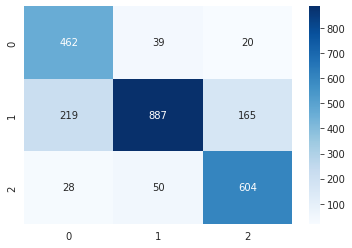

In [43]:
cm_nb = confusion_matrix(val_predictions_nb, val_df['target'].values)
map_cm_nb = sns.heatmap(cm_nb, annot= True, cmap='Blues', fmt="g")
#figure = map_cm_nb.get_figure()    
#figure.savefig('cm_nb.png')

In [44]:
# Creating a submission

X_train_counts = count_vect.fit_transform(list(train_df['text_lemmatized'].values) + list(val_df['text_lemmatized'].values))
X_test_counts = count_vect.transform(list(test_df['text_lemmatized'].values))

clf = MultinomialNB().fit(X_train_counts, np.hstack([train_df['target'].values, val_df['target'].values]))
test_predictions_nb = clf.predict(X_test_counts)

submission_df = pd.DataFrame()
submission_df['textID'] = test_df['textID']
submission_df['sentiment'] = test_predictions_nb
submission_df.to_csv('submission_fullpp_NB.csv', index=False)

**For LSTM**

In [51]:
accuracy_model = (train_predictions_lstm == train_df['target'].values).mean()
print('The train accuracy of our LSTM classifier is: {:.2f}%'.format(accuracy_model*100))
print('The train F1-score of our LSTM classifier is: {:.2f}%'.format(precision_recall_fscore_support(train_df['target'].values,train_predictions_lstm,average='macro',labels=[0,-1,1])[2]*100))

accuracy_model = (val_predictions_lstm == val_df['target'].values).mean()
print('The validation accuracy of our LSTM classifier is: {:.2f}%'.format(accuracy_model*100))
print('The train F1-score of our LSTM classifier is: {:.2f}%'.format(precision_recall_fscore_support(val_df['target'].values,val_predictions_lstm,average='macro',labels=[0,-1,1])[2]*100))



The train accuracy of our LSTM classifier is: 82.42%
The train F1-score of our LSTM classifier is: 81.89%
The validation accuracy of our LSTM classifier is: 80.76%
The train F1-score of our LSTM classifier is: 80.34%


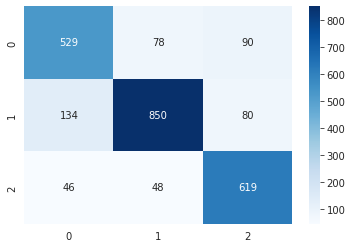

In [55]:
cm_nb = confusion_matrix(val_predictions_lstm, val_df['target'].values)
map_cm_nb = sns.heatmap(cm_nb, annot= True, cmap='Blues', fmt="g")
#figure = map_cm_nb.get_figure()    
#figure.savefig('cm_nb.png')

In [54]:
test_pred_lstm = lstm_model.predict(pad_test)
test_pred_model_lstm = (test_pred_lstm == test_pred_lstm.max(axis=1)[:,None]).astype(int)
test_predictions_lstm = inverse_dummy_function(test_pred_model_lstm)

submission_df = pd.DataFrame()
submission_df['textID'] = test_df['textID']
submission_df['sentiment'] = test_predictions_lstm
submission_df.to_csv('LSTM_sumbmission_stemmed2-1000.csv', index=False)

100%|██████████| 2748/2748 [00:00<00:00, 60304.86it/s]
